Phân tích cảm xúc là một bài toán thuộc phân khúc 'xử lý ngôn ngữ tự nhiên', ở đó những đoạn chữ được hiểu và ý nghĩa của nó được phân tích. Trong phần này, ta sẽ khám phá làm sao để tiên đoán cảm xúc của các bài phê bình về phim. Liệu bài nào là phê bình tích cực, bài nào tiêu cực bằng Python sử dụng thư viện Keras.
- Làm sao để load dữ liệu phê bình của IMDB bằng Keras
- Làm sao để sử dụng word embedding trong Keras cho xử lý ngôn ngữ tự nhiên
- Làm sao để phát triển và đánh giá mô hình MultiLayer Perceptron cho bài toán IMDB
- Làm sao để phát triển mô hình CNN 1 chiều cho bài toán IMDB

## I. Load the IMDB Dataset With Keras

In [1]:
import numpy as np
from keras.datasets import imdb
import matplotlib.pyplot as plt

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# load the dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X = np.concatenate((X_train, y_train), axis=0)
y = np.concatenate((X_test, y_test), axis=0)

# summarize size
print('Training data:')
print(X.shape)
print(y.shape)

Using TensorFlow backend.


17465344/17464789 [==============================] - 31s 2us/step
Training data:
(50000,)
(50000,)


In [4]:
# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(X))))

Number of words: 
88586


review length:
Mean 550.15 words (801.616392)


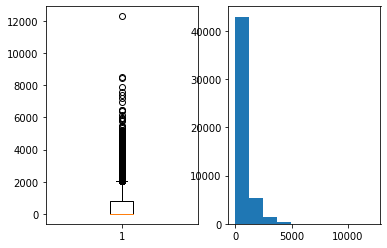

In [8]:
# summarize review length
print('review length:')
result = [len(str(x)) for x in X]
print('Mean %.2f words (%f)' % (np.mean(result), np.std(result)))
# plot review length as a boxplot and histogram
plt.subplot(121)
plt.boxplot(result)
plt.subplot(122)
plt.hist(result)
plt.show()

Một vài block code bị outdate nên khi sửa lại thì kết quả và hình không giống như sách.

## II. Word Embeddings

Một bức phá mới trong ngành xử lý ngôn ngữ tự nhiên có tên là word embedding. Đây là một kĩ thuật mà các từ ở đó được encode như các vector có giá trị thực trong một không gian cao chiều. Ở đó những đặc điểm giống nhau giữa các từ trong khía cạnh ngữ nghĩa diễn dịch chặt chẽ trong một không gian vector. Những từ rời rạc được map vào các vector như các số liên tục. Điều này thì hữu ích khi làm việc với bài toán ngôn ngữ tự nhiên trong những mạng nơ-ron mà chúng ta cần giá trị input là những **con số**.

Chúng ta sẽ sử dụng word embedding cho bộ dữ liệu IMDB. Cho là, chúng ta chỉ quan tâm đến 5000 từ được sử dụng nhiều nhất trong bộ dữ liệu này. Theo đó kích cỡ của từ vựng sẽ là 5000 từ. Chúng ta có thể sử dụng một vector 32 chiều để đại diện cho từng từ. Cuối cùng ta dừng lại ở độ dài review tối đa 500 từ, rút ngắn những review dài hơn và nhồi vào (pad) những review ngắn hơn bằng các giá trị 0. Load dữ liệu IMDB theo cách sau:<br>
`imdb.load_data(num_words=5000)`<br>
Chúng ta sau đó sử dụng Keras utility để rút ngắn hoặc pad dữ liệu này thành độ dài 500 cho mỗi quan sát bằng sử dụng hàm **sequence.pad sequences()**<br>
`X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)`<br>
Cuối cùng layer đầu tiên của mô hình chúng ta là một word embedding layer được tạo bằng **Embedding** class<br>
`Embedding(5000, 32, input_length=500)`<br>
Output của layer đầu tiên sẽ là một ma trận 32x500 cho mỗi bình luận phim trên tập train và test theo dạng số nguyên.

## III. Simple Multilayer Perceptron Model

In [9]:
# MLP for the IMDB problem
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Giờ chúng ta sẽ load bộ dữ liệu IMDB. Chúng ta sẽ đơn giản hóa bộ dữ liệu như đã thảo luận ở trên. Chỉ load 5000 từ. Và tách 50% là train , 50% là test

In [10]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

Bước tiếp theo là giới hạn mỗi review chỉ 500 từ. Lược bỏ những review dài hơn, và nhồi thêm giá trị 0 vào những review ngắn hơn.

In [15]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

Giờ chúng ta có thể tạo mô hình. Input layer đầu tiên là Embedding layer với bộ từ vựng là 5000, vector của từ có kích cỡ 32 chiều và độ dài 500. Output của layer đầu tiên là một ma trận có kích cỡ 32x500. Sau đó ta flat nó thành Embedding layers output thành 1 chiều. Sử dụng Dense layer với 250 node và activation 'ReLU'. Layer output cuối cùng có 1 node và dùng 'sigmoid' activation vì tiên đoán chỉ có 0 hoặc 1. Mô hình biên dịch với loss là logarithmic và optimizer là adam.

In [20]:
# create model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 251       
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_________________________________________________________________
None


Giờ chúng ta có thể fit mô hình và bộ test như validation trong quá trình train. Mô hình này overfit rất nhanh nên chỉ dùng 2 epoch. Vì có nhiều dữ liệu nên ta dùng batch_size = 128. Sau khi train ta đánh giá độ chính xác trên tập test.

In [21]:
# fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=2, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f%%' % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 3s 102us/step - loss: 0.4859 - acc: 0.7397 - val_loss: 0.3076 - val_acc: 0.8686
Epoch 2/2
25000/25000 [==============================] - 2s 81us/step - loss: 0.1815 - acc: 0.9320 - val_loss: 0.3032 - val_acc: 0.8772
Accuracy: 87.72%


Với một mô hình rất đơn giản, ta đã được được đến độ chính xác đến 87.72%. Ta mong đợi rằng, ta có thể làm tốt hơn khi sử dụng embedding layer và các hidden layer lớn hơn.

## IV. One-Dimensional Convolutional Neural Network

CNN được thiết kế để vinh danh cấu trúc không gian trong dữ liệu hình ảnh, trong khi mạnh về vị trí và định hướng đối tượng học qua phân cảnh. Cũng cùng nguyên tắc này có thể được sử dụng trong sequences, như sequence 1 chiều các từ trong bình luận phim.

Cùng yếu tố đó khiến mô hình CNN hấp dẫn cho việc học để nhận dạng đối tượng trong hình ảnh, có thể giúp để học cấu trúc đoạn văn các từ, đó là kĩ thuật bất biến để cụ thể hóa vị trí của các features.

In [23]:
del model

In [22]:
# CNN for the IMDB problem
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Load dữ liệu IMDB giống như đã làm ở trên

In [24]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test)= imdb.load_data(num_words=top_words)
# pad dataset to a maximum review length in words
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

Giờ chúng ta định ra mô hình CNN. Sau input layer **Embedding**, ta chèn vào một Convolutional Layer 1D (**Conv1D**). Convolutional layer này có 32 features map và đọc các embedded word đại diện cho 3 phần tử của vector của word embedding đó trong mỗi lần. Theo sau là một Maxpooling layer 1D với độ dài là 2 chia đôi kích cỡ feature map của convolutional layer trước đó. Và phần còn lại y như ở trên.

In [25]:
# create model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               2000250   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 251       
Total params: 2,163,605
Trainable params: 2,163,605
Non-trainable params: 0
_________________________________________________________________


Fit model y như ở trên.

In [26]:
#fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128 ,verbose=2 )
# final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy %.2f%%' % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 5s - loss: 0.4793 - acc: 0.7382 - val_loss: 0.2817 - val_acc: 0.8834
Epoch 2/2
 - 2s - loss: 0.2234 - acc: 0.9118 - val_loss: 0.2773 - val_acc: 0.8834
Accuracy 88.34%


Chỉ cần thay đổi một chút nhỏ nhưng điểm của mô hình đã được cải thiện tốt (từ 87.72 lên 88.34).<br>
Vẫn còn nhiều cơ hội để chúng ta tối ưu hóa xa hơn nữa. Như sử dụng deeper hoặc larger các convolutional layers. Một ý tưởng thú vị là chỉnh MaxPooling layer để sử dụng input với độ dài là 500. Điều này có thể nén các feature map thành một vector đơn có độ dài 32 và có thể tăng khả năng biểu diễn.

**Thử nghiệm ý tưởng trên**

In [55]:
del model
# create model
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=1)) # Sử dụng độ dài tối đa của input
model.add(Flatten())
model.add(Dense(500, activation='relu')) # larger layer
model.add(Dense(1, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128 ,verbose=2 )
# final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy %.2f%%' % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 500, 32)           160000    
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 500, 32)           0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 16000)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 500)               8000500   
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 501       
Total params: 8,164,105
Trainable params: 8,164,105
Non-trainable params: 0
_________________________________________________________________


In [49]:
del model